## 0. Librerías.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
os.chdir("C:\\Users\\jorge\\Desktop\\Máster\\Módulo 7 - Minería de datos y modelización predictiva\\Parte 2\\Tarea")
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from FuncionesMineria2 import (plot_varianza_explicada, plot_cos2_heatmap, plot_corr_cos, plot_cos2_bars, plot_contribuciones_proporcionales, plot_pca_scatter, plot_pca_scatter_with_vectors, plot_pca_scatter_with_categories)

## 0. Lectura de datos.

In [3]:
df = sns.load_dataset("penguins")
df.columns = ['Especie', 'Isla', 'Longitud del pico', 'Profundidad del pico', 'Longitud de la aleta', 'Masa', 'Sexo']
display(df.head())
variables = df.columns.tolist()
v_numericas = df.select_dtypes(include = ['int', 'float']).columns.tolist()
v_categoricas = [var for var in variables if var not in v_numericas]

,Especie,Isla,Longitud del pico,Profundidad del pico,Longitud de la aleta,Masa,Sexo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


### 1.1. Tabla de estadísticos.

In [4]:
estadisticos = pd.DataFrame({
    'Mínimo': df[v_numericas].min(),
    'Q1': df[v_numericas].quantile(0.25),
    'Mediana': df[v_numericas].median(),
    'Q3': df[v_numericas].quantile(0.75),
    'Media': df[v_numericas].mean(),
    'Máximo': df[v_numericas].max(),
    'Desv. típica': df[v_numericas].std(),
    'Varianza': df[v_numericas].var(),
    'Coef. de Variación': (df[v_numericas].std() / df[v_numericas].mean()),
    'Missing': df[v_numericas].isna().sum()
})
estadisticos = estadisticos.round(decimals = 2)
display(estadisticos)

,Mínimo,Q1,Mediana,Q3,Media,Máximo,Desv. típica,Varianza,Coef. de Variación,Missing
Longitud del pico,32.1,39.22,44.45,48.5,43.92,59.6,5.46,29.81,0.12,2
Profundidad del pico,13.1,15.60,17.30,18.7,17.15,21.5,1.97,3.90,0.12,2
Longitud de la aleta,172.0,190.00,197.00,213.0,200.92,231.0,14.06,197.73,0.07,2
Masa,2700.0,3550.00,4050.00,4750.0,4201.75,6300.0,801.95,643131.08,0.19,2


### 1.2. Gráfico de dispersión.

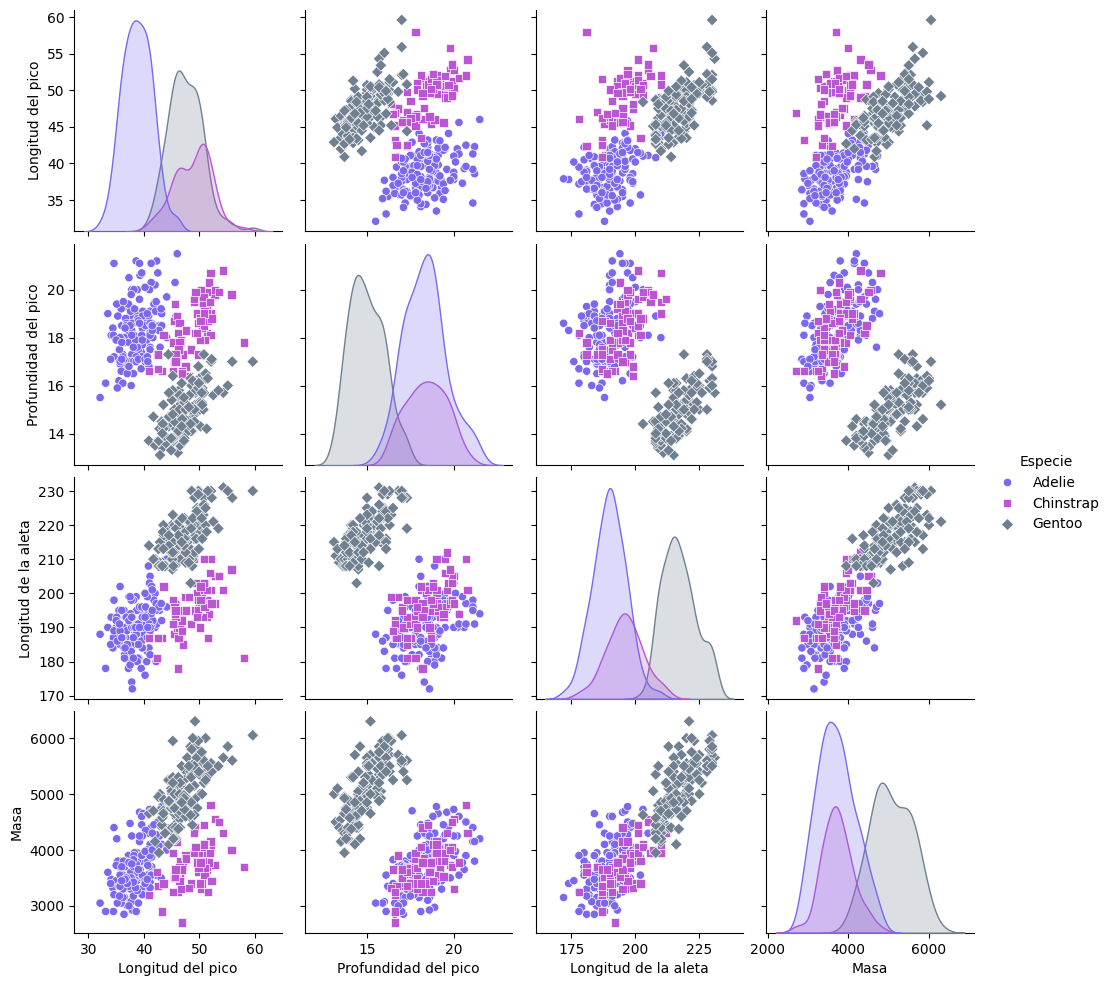

In [5]:
sns.pairplot(df, 
             vars = v_numericas, 
             hue = 'Especie',
             diag_kind = 'kde',
             markers = ['o', 's', 'D'],
             palette = ['#7B68EE', '#BA55D3', '#708090']
)
plt.show()

## 1. Matriz de correlación.

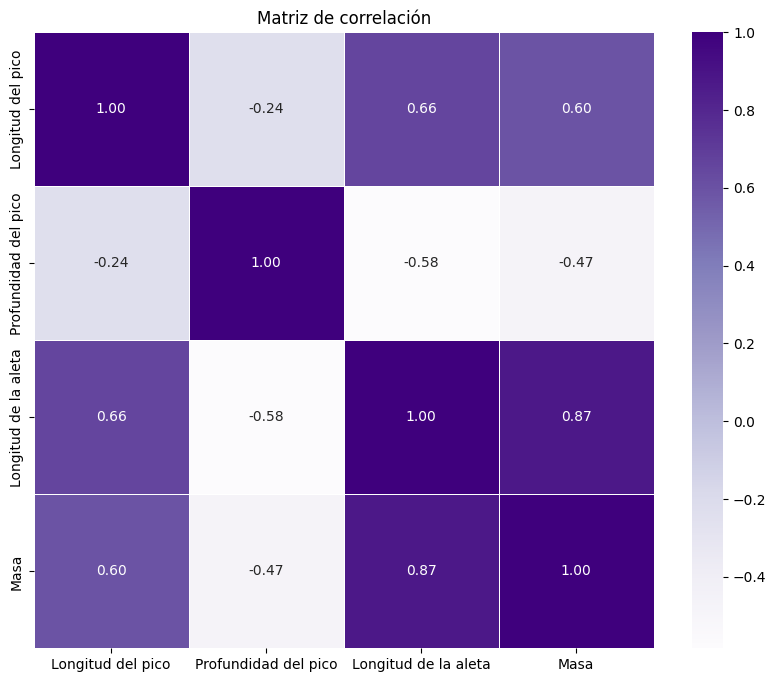

In [6]:
R = df[v_numericas].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(R, annot = True, cmap = 'Purples', fmt = '.2f', linewidths = 0.5)
plt.title('Matriz de correlación')
plt.show()

## 2. Análisis de componentes principales.

,Longitud del pico_z,Profundidad del pico_z,Longitud de la aleta_z,Masa_z
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
4,-1.324737,1.089724,-0.563715,-0.938776
5,-0.847812,1.748985,-0.777373,-0.689020


,Autovalores,Variabilidad Explicada,Variabilidad Acumulada
Componente 1,2.761831,0.688439,0.688439
Componente 2,0.774782,0.193129,0.881568
Componente 3,0.366307,0.091309,0.972877
Componente 4,0.108810,0.027123,1.000000


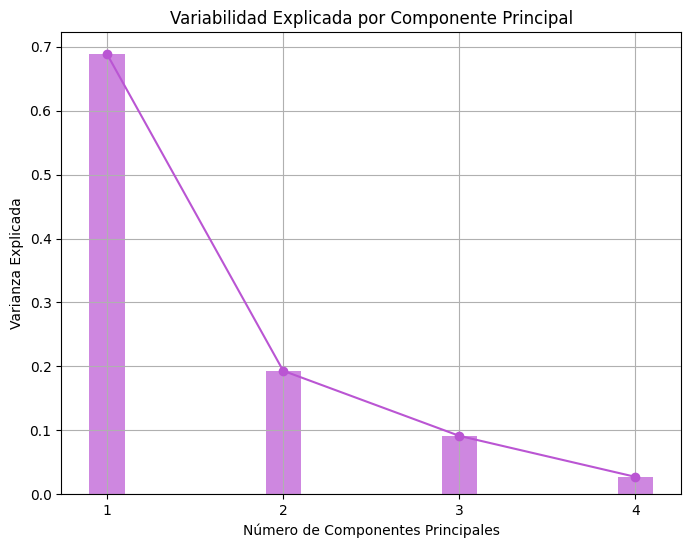

In [7]:
df_std = pd.DataFrame(
    StandardScaler().fit_transform(df[v_numericas]),
    columns=['{}_z'.format(variable) for variable in v_numericas]).dropna()
display(df_std.head())
pca = PCA(n_components = 4)
fit = pca.fit(df_std)
autovalores = fit.explained_variance_
var_explicada = fit.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)])
display(tabla)
plot_varianza_explicada(var_explicada, fit.n_components_)

## 3. Segundo análisis de componentes principales.

In [8]:
pca = PCA(n_components = 2)
fit = pca.fit(df_std)
autovectores = pca.components_
autovectores = pd.DataFrame(pca.components_.T,
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in v_numericas])
display(autovectores)
resultados_pca = pd.DataFrame(fit.transform(df_std),
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=df_std.index)

df_z_cp = pd.concat([df_std, resultados_pca], axis=1)
display(df_z_cp)

,Autovector 1,Autovector 2
Longitud del pico_z,0.455250,0.597031
Profundidad del pico_z,-0.400335,0.797767
Longitud de la aleta_z,0.576013,0.002282
Masa_z,0.548350,0.084363


,Longitud del pico_z,Profundidad del pico_z,Longitud de la aleta_z,Masa_z,Componente 1,Componente 2
0,-0.884499,0.785449,-1.418347,-0.564142,-1.843445,0.047702
1,-0.811126,0.126188,-1.062250,-0.501703,-1.306762,-0.428348
2,-0.664380,0.430462,-0.421277,-1.188532,-1.369181,-0.154476
4,-1.324737,1.089724,-0.563715,-0.938776,-1.878827,-0.002048
5,-0.847812,1.748985,-0.777373,-0.689020,-1.911748,0.829210
...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,2.006436,-0.958909
340,0.527932,-1.445897,1.003109,0.809516,1.840886,-0.767714
341,1.188289,-0.735923,1.501644,1.933419,2.760742,0.288886
342,0.234440,-1.192335,0.789451,1.246590,1.722364,-0.704269


### 3.1. Correlación entre las variables originales y las componentes seleccionadas.

,Componente 1,Componente 2
Longitud del pico_z,0.755463,0.524748
Profundidad del pico_z,-0.664333,0.701180
Longitud de la aleta_z,0.955862,0.002006
Masa_z,0.909957,0.074149


,Componente 1,Componente 2
Longitud del pico_z,0.570724,0.275361
Profundidad del pico_z,0.441338,0.491654
Longitud de la aleta_z,0.913672,0.000004
Masa_z,0.828021,0.005498


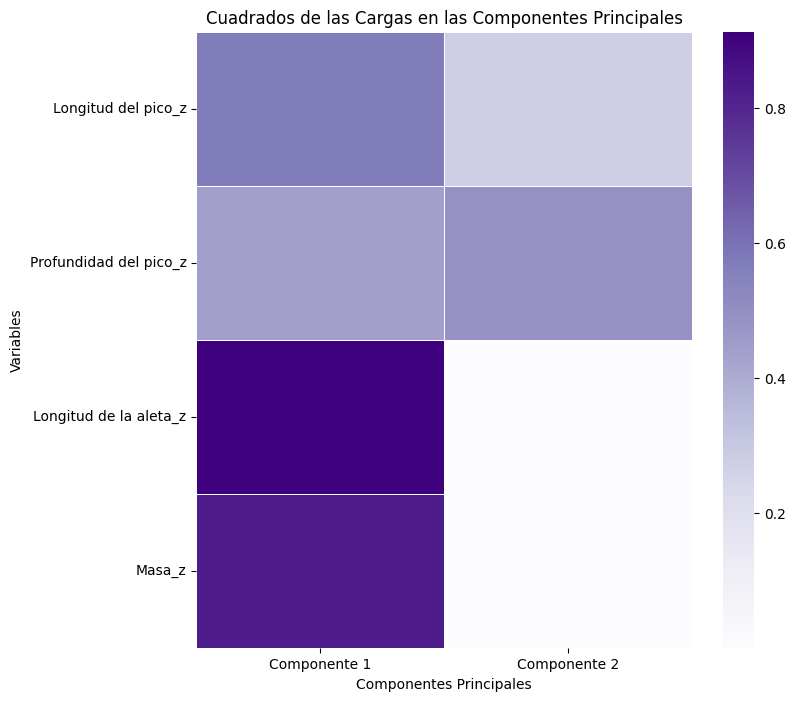

In [ ]:
variables_cp = df_z_cp.columns
correlacion = pd.DataFrame(np.corrcoef(df_std.T, resultados_pca.T),
                           index = variables_cp, columns = variables_cp)

n_variables = fit.n_features_in_
correlaciones_df_con_cp = correlacion.iloc[:fit.n_features_in_, fit.n_features_in_:]
display(correlaciones_df_con_cp)


cos2 = correlaciones_df_con_cp**2
display(cos2)
plot_cos2_heatmap(cos2)

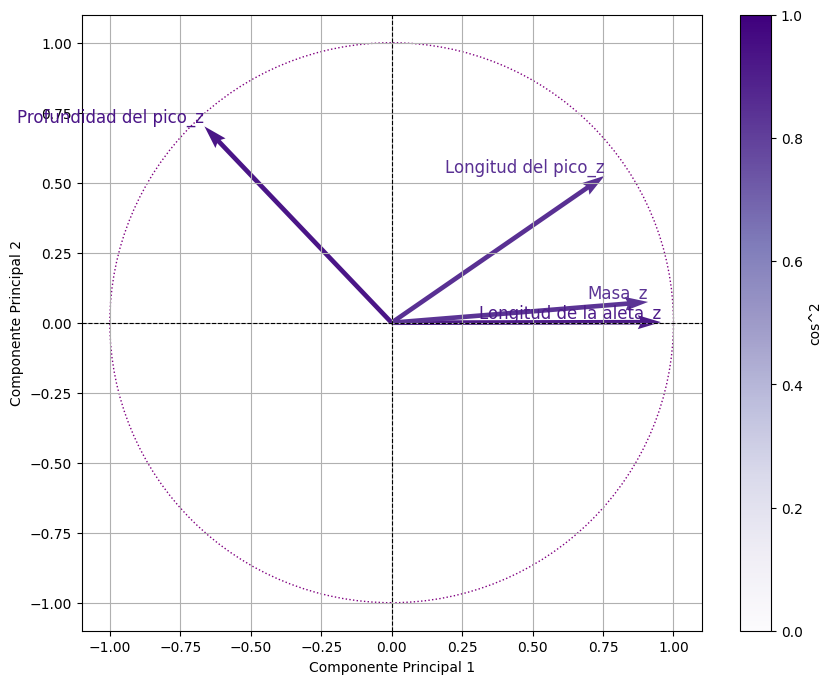

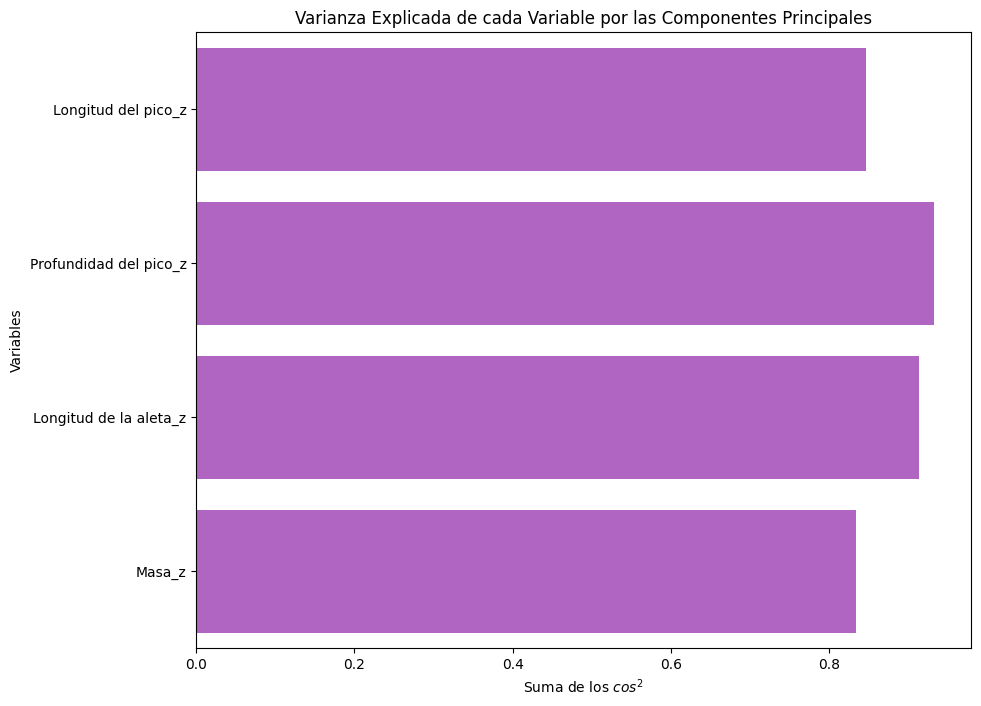

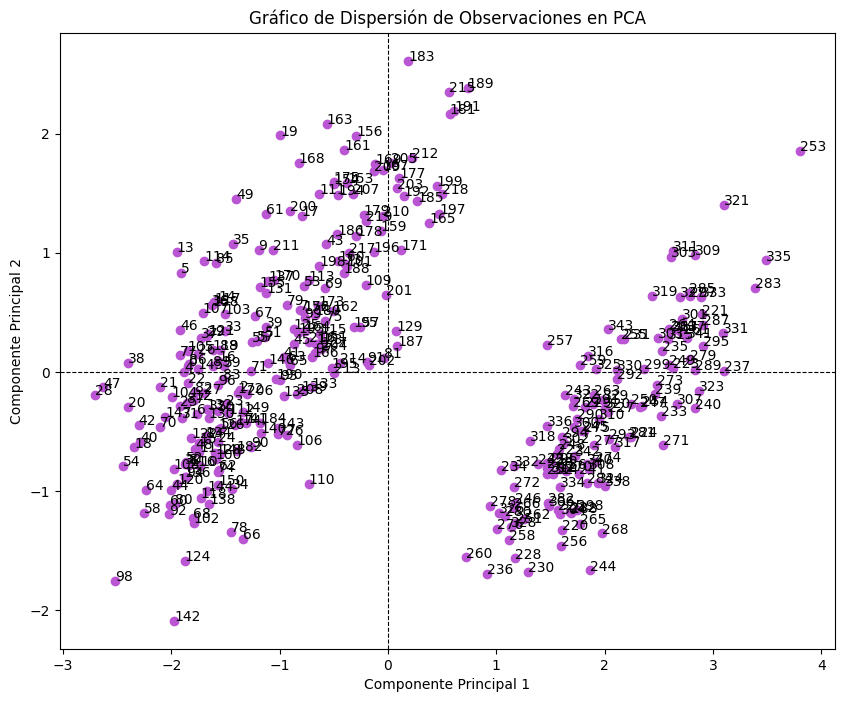

In [10]:
plot_corr_cos(fit.n_components, correlaciones_df_con_cp)
plot_cos2_bars(cos2)
plot_pca_scatter(pca, df_std, fit.n_components)

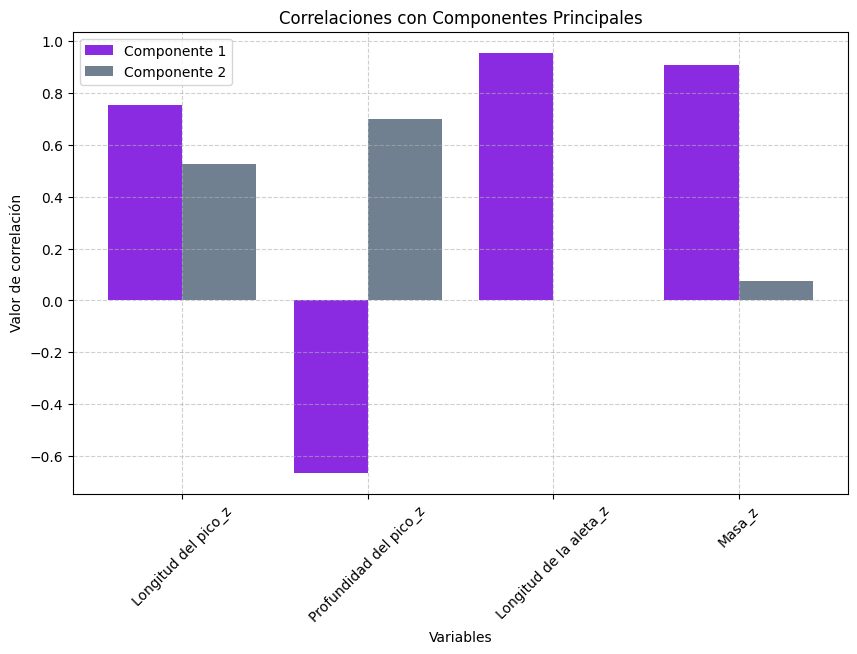

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
indices = np.arange(len(correlaciones_df_con_cp))
ancho = 0.4  
ax.bar(indices - ancho/2, correlaciones_df_con_cp['Componente 1'], width=ancho, color='#8A2BE2', label='Componente 1')
ax.bar(indices + ancho/2, correlaciones_df_con_cp['Componente 2'], width=ancho, color='#708090', label='Componente 2')
ax.set_xticks(indices)
ax.set_xticklabels(correlaciones_df_con_cp.index)
ax.set_ylabel('Valor de correlación')
ax.set_xlabel('Variables')
ax.set_title('Correlaciones con Componentes Principales')
ax.legend()
plt.grid(True, linestyle='--', alpha=0.6, zorder = 0)
plt.xticks(rotation=45)
plt.show()

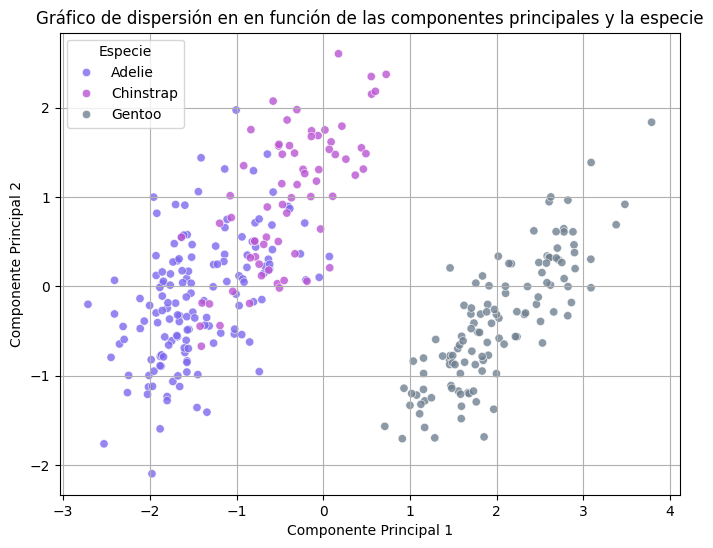

In [12]:
df = sns.load_dataset('penguins')
df.columns = ['Especie', 'Isla', 'Longitud del pico', 'Profundidad del pico', 
              'Longitud de la aleta', 'Masa', 'Sexo']
df = df.dropna()
X = df[['Longitud del pico', 'Profundidad del pico', 'Longitud de la aleta', 'Masa']]
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Especie'] = df['Especie'].values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Especie', data=df_pca, palette = ['#7B68EE', '#BA55D3', '#708090'], alpha=0.8)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión en en función de las componentes principales y la especie')
plt.legend(title='Especie')
plt.grid()
plt.show()

In [13]:
df = df.dropna()
datos_std = StandardScaler().fit_transform(df[v_numericas])
df_std = pd.DataFrame(datos_std, columns=df[v_numericas].columns, index=df.index)
pca = PCA(n_components = 2)

fit = pca.fit_transform(df_std)
df_pca = pd.DataFrame(fit, columns=['PC1', 'PC2'])
df_pca['Especie'] = df['Especie'].values

coef = [1, 1]
df_pca['Índice PCA'] = np.dot(df_pca[['PC1', 'PC2']], coef)

index_adelie_pca = df_pca[df_pca['Especie'] == 'Adelie']['Índice PCA'].mean()
index_chinstrap_pca = df_pca[df_pca['Especie'] == 'Chinstrap']['Índice PCA'].mean()
index_gentoo_pca = df_pca[df_pca['Especie'] == 'Gentoo']['Índice PCA'].mean()

print(f"Valor del índice PCA para la especie 'Adelie': {index_adelie_pca}")
print(f"Valor del índice PCA para la especie 'Chinstrap': {index_chinstrap_pca}")
print(f"Valor del índice PCA para la especie 'Gentoo': {index_gentoo_pca}")

Valor del índice PCA para la especie 'Adelie': -1.6012247910501518
Valor del índice PCA para la especie 'Chinstrap': 0.6047644110912527
Valor del índice PCA para la especie 'Gentoo': 1.618948231421151


In [14]:
df[df['Especie'] == 'Gentoo'].count()

Especie                 119
Isla                    119
Longitud del pico       119
Profundidad del pico    119
Longitud de la aleta    119
Masa                    119
Sexo                    119
dtype: int64

## 4. Clustering. Número de grupos.

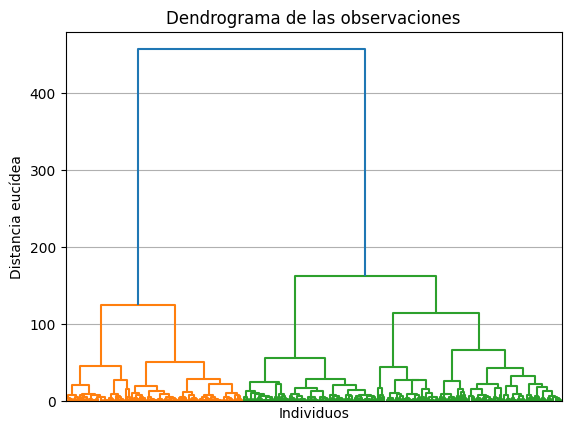

In [15]:
distance_std = distance.cdist(df_std, df_std,"euclidean")
df_std_distance = pd.DataFrame(distance_std, index = df_std.index, columns = df.index)
linkage_matrix = sch.linkage(df_std_distance, method='ward')  # You can choose a different linkage method if needed
dendrogram = sch.dendrogram(linkage_matrix, labels=df.index, leaf_font_size=9, leaf_rotation=90)
plt.title('Dendrograma de las observaciones')
plt.xlabel('Individuos')
plt.ylabel('Distancia eucídea')
plt.xticks([], [])
plt.grid()
plt.show()

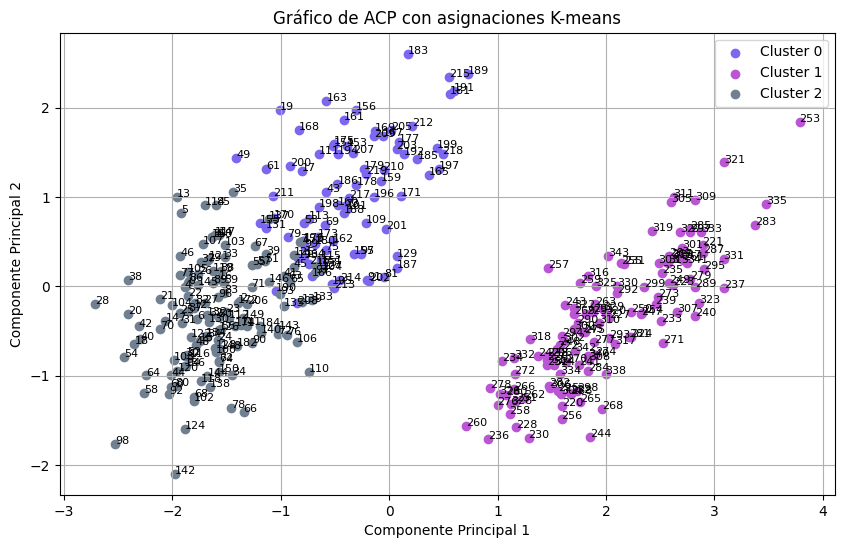

In [16]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df_std)
kmeans_cluster_labels = kmeans.labels_
plt.figure(figsize=(10, 6))

for cluster, color in zip(np.unique(kmeans_cluster_labels), ['#7B68EE', '#BA55D3', '#708090']):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}',
                color = color)
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df.index[i]), fontsize=8)

plt.title("Gráfico de ACP con asignaciones K-means")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()

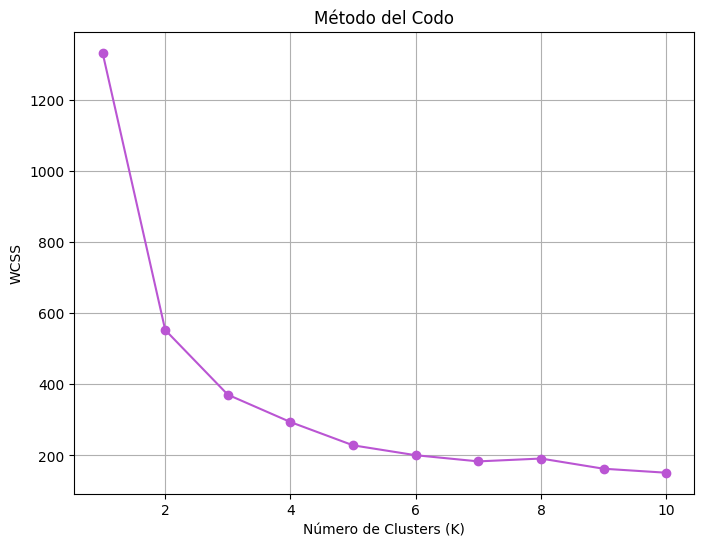

In [17]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='mediumorchid')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS')
plt.grid()
plt.show()

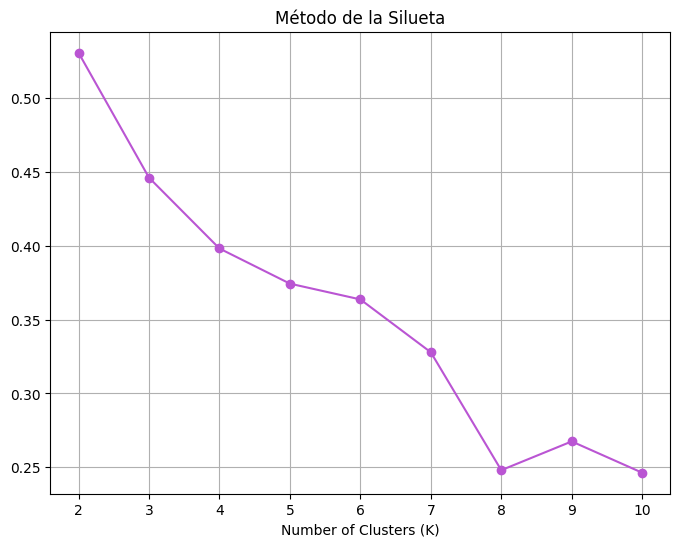

In [21]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_std, labels)
    silhouette_scores.append(silhouette_avg)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle ='-', color='mediumorchid')
plt.title('Método de la Silueta')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('')
plt.grid(True)
plt.show()

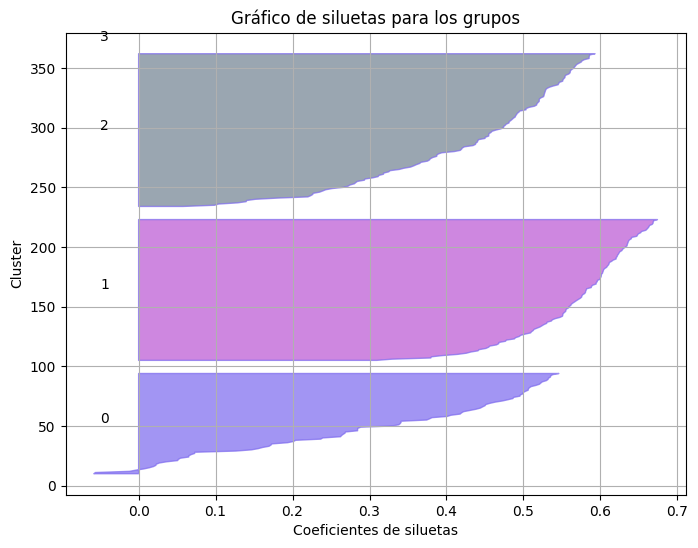

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_std)
labels = kmeans.labels_
silhouette_values = silhouette_samples(df_std, labels)
plt.figure(figsize=(8, 6))
y_lower = 10
color = ['#7B68EE', '#BA55D3', '#708090', '#708090']
for i in range(4):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color[i], edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.title("Gráfico de siluetas para los grupos")
plt.xlabel("Coeficientes de siluetas")
plt.ylabel("Cluster")
plt.grid(True)
plt.show()